### Введение
Данный проект был написан в рамках хакатона, проводимого летней школой СЛОН http://school-slon.ru/. В рамках выполнения задания была построена модель для определения временной принадлежности картины/фрески к тому или иному историческому периоду.

### Описание алгоритма
Данные брались с сайта 
https://www.wga.hu


In [1]:
import pandas
import os
import seaborn as sns
from tqdm.notebook import tqdm
import numpy
import pickle
import torch
path2data = '../../data/wga/'
df = pandas.read_csv(os.path.join(path2data, 'prepared.csv'), header=None)
df

,0,1
0,42b4327281e1bb16e19647d5aac727ab.jpg,1574
1,f0aa8fe52e17ae347b51f5447b63401c.jpg,1598
2,a16b6a572701af2fba7ad2f4fc01a01c.jpg,1602
3,b8c48933d18e247f02f204f758280a63.jpg,1595
4,57cb980521e2a7772224a782c34367d4.jpg,1593
...,...,...
44654,853d91d71288c90a914e67e808714aea.jpg,1682
44655,b9c51c05af63efc1f7005922fcff53f3.jpg,1854
44656,a11eb6f75a934dd5e920abfb092ed199.jpg,1854
44657,fd303c60e82940feb4559387621e70b9.jpg,1854


Распредение по векам

In [2]:
df['century'] = (df[1] - 1) // 100 + 1

44655
   centuries  # of paintings
0          1               2
1          2              23
2          3              45
3          4             133
4          5             103


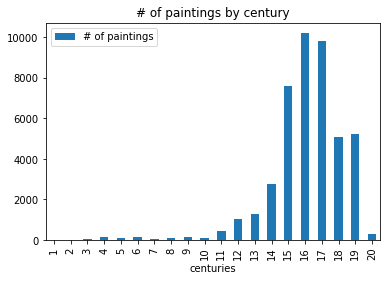

In [3]:

def make_freq_bar_chart(col):
    dct = {}
    print(len(col))
    for el in col:
        if el in dct:
            dct[el] += 1
        else:
            dct[el] = 1
    
    data = {"centuries": [], "# of paintings": []}
    for el in sorted(dct.items(), key=lambda x: x[0]):
        data['centuries'].append(el[0])
        data['# of paintings'].append(el[1])
    df = pandas.DataFrame(data=data)
    print(df.head())
    return df.plot.bar(x="centuries", y="# of paintings", title="# of paintings by century");
    #plot.show(block=True);

df = df[df[1] <= 2020]
make_freq_bar_chart(df['century'])
# df.hist(column='century')[0]
# sns.distplot(df['century'], kde=False, rug=True);

44655
   centuries  # of paintings
0          0            3685
1          1            1716
2          2            1048
3          3            2497
4          4            5089


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


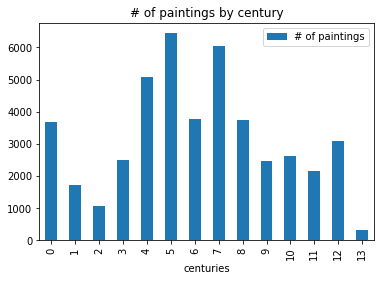

In [4]:
def year2class(year):
    bounds = [i + 1 for i in range(1300, 2051, 50)]
    # print(bounds)
    for i in range(len(bounds)):
        if year < bounds[i]:
            # print(year, bounds[i], i)
            return i
    raise Exception(year)
        


df['classes'] = df[1].apply(year2class)
make_freq_bar_chart(df['classes'])

Для большего баланса классов было решено объединить период 201-1300 гг  
![](../README/data.png)  


In [20]:
to_process = df[df['classes'] < 13]
to_process.head()

,0,1,century,classes
0,42b4327281e1bb16e19647d5aac727ab.jpg,1574,16,6
1,f0aa8fe52e17ae347b51f5447b63401c.jpg,1598,16,6
2,a16b6a572701af2fba7ad2f4fc01a01c.jpg,1602,17,7
3,b8c48933d18e247f02f204f758280a63.jpg,1595,16,6
4,57cb980521e2a7772224a782c34367d4.jpg,1593,16,6


In [21]:
class2ids = dict()
for row in to_process.iterrows():
    ind = row[0]
    row = row[1]
    cid = row['classes']
    if cid not in class2ids:
        class2ids[cid] = [ind]
    else:
        class2ids[cid].append(ind)
mn = -1
for el in class2ids:
    print(el, len(class2ids[el]))
    if mn == -1 or len(class2ids[el]) < mn:
        mn = len(class2ids[el])
print('mn', mn)

6 3759
7 6052
12 3093
4 5089
5 6452
8 3749
11 2141
10 2616
9 2455
1 1716
3 2497
2 1048
0 3685
mn 1048


In [22]:
from random import shuffle
import pickle

for el in class2ids:
    shuffle(class2ids[el])
    class2ids[el] = class2ids[el][:mn]
good_rows = []
for el in class2ids:
    for rid in class2ids[el]:
        good_rows.append(to_process.loc[rid])
balanced_df = pandas.DataFrame(good_rows)
balanced_df.head()

with open('balanced.pkl', 'wb') as file:
    pickle.dump(balanced_df, file=file)

Для решения задачи была использована следующая модель:
![](../README/model_architecture.png)  
- Сеть vgg19 до слоя conv_5_1 (1)


In [23]:
from PIL import Image
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch

device = torch.device('cpu' if torch.cuda.device_count() == 0 else 'cuda:0')
DATA_SIZE = 224

class Resize:
  pad_color = [0, 0, 0]
  def __init__(self, image_size=DATA_SIZE):
    self.image_size = image_size

  def __call__(self, img):
    width, height = img.size
    scale_f = max(width, height) / self.image_size
    width_new = int(width / scale_f)
    height_new = int(height / scale_f)
    img = img.resize((width_new, height_new))
    return img

class RudeResize:
    def __init__(self, image_size=DATA_SIZE):
        self.image_size = image_size
    
    def __call__(self, img):
        return img.resize((self.image_size, self.image_size))

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class MyTransform:
    def __init__(self):
        model_ft = models.vgg19(pretrained=True)
        self.net = torch.nn.Sequential(
           *model_ft.features[:26],
        ).to(device)
        '''self.before = transforms.Compose([
            Resize(DATA_SIZE * 4),
            transforms.CenterCrop((DATA_SIZE, DATA_SIZE)),
        #    transforms.ColorJitter(0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])'''
        self.before = transforms.Compose([
            RudeResize(DATA_SIZE),
        #    transforms.ColorJitter(0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
        
        print(self.net)
    
    def __call__(self, img):
        # print(img)
        #print(img.size)
        img = self.before(img).to(device)
        #print(img.shape)
        with torch.no_grad():
            img = self.net(img.unsqueeze(0))
        img = gram_matrix(img).cpu().view(-1)
        #print(img.shape)
        return img.numpy()

transform = MyTransform()

def net_row_transform(row):
    path = os.path.join('../../data/wga/art/', row[0])
    # print(row, len(row))
    class_id = row['classes']
    try:
        img = Image.open(path).convert("RGB")
    except:
        return None
    return transform(img),  class_id

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [9]:
import numpy
def equal_bin(N, m):
    sep = (N.size/float(m))*numpy.arange(1,m+1)
    idx = sep.searchsorted(numpy.arange(N.size))
    return idx[N.argsort().argsort()]

def equal_bin_v2(N, m):
    idx = numpy.linspace(0,m,N.size+1, endpoint=0).astype(int)
    return idx[N.argsort().argsort()]  

N = numpy.arange(1,100)
numpy.bincount(equal_bin_v2(N, 10))
print(equal_bin(N, 10))
print(N)


[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98 99]


In [ ]:
!mkdir table
import pickle

files = []
y_file = open('table/y', 'w')
for row in tqdm(to_process.iterrows(), total=len(to_process)):
    result = net_row_transform(row[1])
    if result is None:
        continue
    arr, class_id = result
    arr = arr.reshape(-1, 1024)
    for i in range(arr.shape[0]):
        if len(files) == i:
            files.append(open(f'table/{i}.pkl', 'wb'))
        pickle.dump(arr[i], files[i])
    print(class_id, file=y_file, end=' ')
y_file.close()
for el in files:
    el.close()

In [51]:
import pickle
feature2corr = []
y = [int(el) for el in list(open('table/y').read().split())]
classes = max(y) + 1
n_rows = len(y)
y_true = [[j == y[i] for j in range(classes)]  for i in range(len(y))]
df_y = pandas.DataFrame(y_true)
for i in tqdm(range(256)): # 256
    rows = []
    file = open(f'table/{i}.pkl', 'rb')
    for j in range(n_rows):
        rows.append(pickle.load(file))
    df = pandas.DataFrame.from_records(rows)
    results = [df.corrwith(df_y[i]) for i in range(classes)]
    feature2corr += [[results[j][i] for j in range(classes)] for i in range(1024)]    
with open('correlations.pkl', 'wb') as file:
    pickle.dump(feature2corr, file)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f23d9ccbf28>]],
      dtype=object)

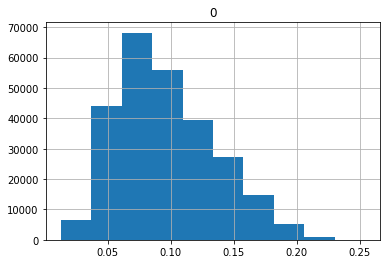

In [23]:
with open('correlations.pkl', 'rb') as file:
    feature2corr = pickle.load(file)
min_features = [(max([abs(el) for el in feature2corr[i]]), i) for i in range(len(feature2corr))]
min_features.sort()

df = pandas.DataFrame([min_features[i][0] for i in range(len(min_features))])
df.hist()

11992
[[[0.1700003233690957, 0.08256955769701402, 0.07953936081912119, 0.07685433085665491, 0.07300949523965028, 0.020639611674061066, -0.02755638172618021, -0.09878054276922109, -0.09790290117700912, -0.08847936069493155, -0.06963006233689104, -0.08239735443436975], 144787], [[0.1700003233690957, 0.08256955769701402, 0.07953936081912119, 0.07685433085665491, 0.07300949523965028, 0.020639611674061066, -0.02755638172618021, -0.09878054276922109, -0.09790290117700912, -0.08847936069493155, -0.06963006233689104, -0.08239735443436975], 206618], [[0.1700005685737498, 0.040185403395557845, 0.05531702094804727, 0.054495724474665046, 0.05107616558739418, -0.0035425685484808986, -0.0023583546308918826, -0.09434456364586537, -0.06664811927166847, -0.028418038491421882, -0.07152191013415447, -0.07320392936603135], 193975]]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f23551dbf28>]],
      dtype=object)

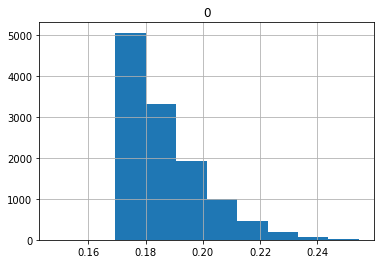

In [26]:
THR = 0.17
ind = 0
left_features = []
for el in min_features:
    if el[0] < THR:
        continue
    left_features.append([feature2corr[el[1]], el[1]])
print(len(left_features))
arr = [abs(left_features[i][0][ind]) for i in range(len(left_features))]
pandas.DataFrame(arr).hist()

In [24]:
import numpy
saved_features = numpy.load('features8000.npy')# numpy.array([el[1] for el in left_features])
with open('balanced.pkl', 'rb') as file:
    balanced_df = pickle.load(file)
X = []
y = []
for row in tqdm(balanced_df.iterrows(), total=len(balanced_df)):
    result = net_row_transform(row[1])
    if result is None:
        print('ooops', list(row[1]))
        continue
    arr, class_id = result
    good_features = arr[saved_features]
    X.append(good_features)
    y.append(class_id) 

ooops ['072ac2f12a5e4bfb0ff29bffdee32e79.jpg', 1567, 16, 6]
ooops ['372e47ae0987e12bafc18942d701db5d.jpg', 1566, 16, 6]
ooops ['123d5864f336d4d6e83e58e125e2cdd8.jpg', 1552, 16, 6]
ooops ['b4010de45a85ab318691b070e586ea1e.jpg', 1559, 16, 6]
ooops ['134a415af64a79b316be53d2702e9679.jpg', 1570, 16, 6]
ooops ['1e68d85bd2f2815e9ffa2c2dfe22dbc8.jpg', 1580, 16, 6]
ooops ['48b97f6162601f4dd3ca09de0760316d.jpg', 1557, 16, 6]
ooops ['7e44009e552e48a3d21dd30572ed6a3b.jpg', 1555, 16, 6]
ooops ['22138df8d1d89b09f9e60f558f1552a2.jpg', 1896, 19, 12]
ooops ['0d435d87a941c0920eaa5cbb102db16e.jpg', 1897, 19, 12]
ooops ['59eaac23a567379876c90c0aed6d42fc.jpg', 1897, 19, 12]
ooops ['5b4664f2d028ced1bfe12d106ebdc5e7.jpg', 1894, 19, 12]
ooops ['65f45ec3e242ff885eaaab63a3c9c2ef.jpg', 1893, 19, 12]
ooops ['3f97db6cb7ef3901c5c0efd222adfaff.jpg', 1894, 19, 12]
ooops ['71516966706af8f88cadf44e3b1c0769.jpg', 1894, 19, 12]
ooops ['2ce519a34cf619d190fadfe40792de40.jpg', 1893, 19, 12]
ooops ['4eba4c156d52cb7d4afd8d6f

13624
   centuries  # of paintings
0          0            1048
1          1            1048
2          2            1048
3          3            1048
4          4            1048


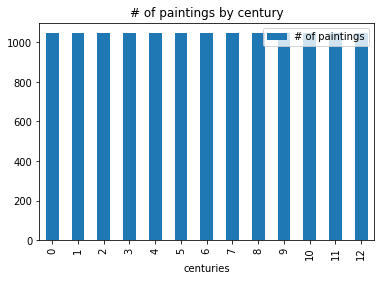

In [25]:
make_freq_bar_chart(balanced_df['classes'])

In [30]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
import numpy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM][[145   0   1   5   0   3  17   0   0   0 121   0]
 [146   0   4   6   0   5  26   1   0   0 136   0]
 [134   0  16   4   0   3  17   2   0   0 123   0]
 [116   0  13   8   0   5  28   3   0   0 140   0]
 [112   0  11  10   0   4  28   1   0   0 171   0]
 [ 62   0   7   8   0   6  26   1   0   0 206   0]
 [ 68   0   2   5   0   4  10   6   0   0 205   0]
 [ 35   0   4   0   0   1  10   1   0   0 261   0]
 [ 50   0   5   2   0   0  15   0   0   0 241   0]
 [ 68   0   2   0   0   2  12   0   0   0 252   0]
 [ 49   0   0   0   0   0   4   0   0   0 248   0]
 [ 42   0   2   2   0   5   8   0   0   0 262   0]]
0.11530286928799148
0.0514403156314307


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


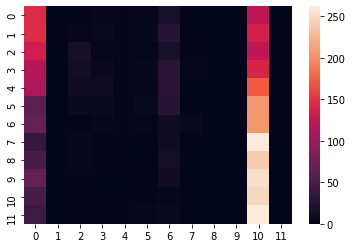

In [24]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
import numpy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = svm.SVC(verbose=1, kernel='sigmoid')
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
confusion = confusion_matrix(y_test, predicted)

In [27]:
import joblib
clf = joblib.load(open('linear_svc_balanced.pkl', 'rb'))

In [31]:
y_test = [el + 16 for el in y_test]

[[199  38  14 152  41  61  80   3   6   3   2   9 329]
 [ 59 283  60 201  21  38  77   1   5   4   4   5 191]
 [ 34  40 210 268  32  50  81   3   2   3   2  10 221]
 [ 25  14  27 368  55  50 103   4   4   5   2   5 251]
 [ 15  11  11 164 189 120 122   3   1   4   3   8 300]
 [ 14  11   2  63  26 295 191   8   1   7   2  16 299]
 [  9   4   2  53   7  77 413  13   3   6   4  21 330]
 [  3   3   2  38  14  66 276 137   9   9  10  26 352]
 [  5   2   4  53  11  70 213  64  28  25  14  34 408]
 [  5   2   2  44  11  64 186  32   3 148  30  31 406]
 [  6   2   2  48  14  63 132  21   5  49 104  57 429]
 [  3   4   1  53   7  45  91   8   3  15  23 116 560]
 [  2   1   1  20   5  13  32   2   2   2   3  18 840]]
0.2723926380368098
0.2589016788447415


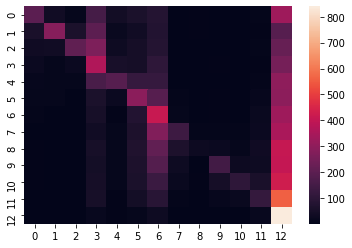

In [32]:
predicted = clf.predict(X_test)

confusion = confusion_matrix(y_test, predicted)
print(confusion)
print(f1_score(y_test, predicted, average='micro'))
print(f1_score(y_test, predicted, average='macro'))
sns.heatmap(confusion)

In [86]:
arr = numpy.load('features8000.npy')
len(arr)
cnt = 0
exists = set(el[1] for el in left_features)
for el in arr:
    if el in exists:
        cnt += 1
print(cnt, len(arr), len(left_features))

1361 8192 11992
